In [3]:
import numpy as np
import sys
sys.path.append("../")
from mlp import mlp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import datetime
import pickle


## Loading data
### Remember that 1 means PD

In [4]:
data = pd.read_csv("../dataset/parkinsons.data")
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## Defining X and y

In [5]:
c = 0
for i in data.columns:
    print c, i 
    c+=1

0 name
1 MDVP:Fo(Hz)
2 MDVP:Fhi(Hz)
3 MDVP:Flo(Hz)
4 MDVP:Jitter(%)
5 MDVP:Jitter(Abs)
6 MDVP:RAP
7 MDVP:PPQ
8 Jitter:DDP
9 MDVP:Shimmer
10 MDVP:Shimmer(dB)
11 Shimmer:APQ3
12 Shimmer:APQ5
13 MDVP:APQ
14 Shimmer:DDA
15 NHR
16 HNR
17 status
18 RPDE
19 DFA
20 spread1
21 spread2
22 D2
23 PPE


In [6]:
print "total PD", data.status.values.tolist().count(1)
print "total no PD", data.status.values.tolist().count(0)
# as the number of PD and no PD is hugely different, resampling to get even amounts
pd_index = data.index[data.loc[:, "status"]==1]
nopd_index = data.index[data.loc[:, "status"]==0]
print pd_index.shape
print nopd_index.shape
#making data more even
my_index = np.hstack((pd_index[:48], nopd_index))
print my_index.shape

total PD 147
total no PD 48
(147,)
(48,)
(96,)


In [7]:
scaler = MinMaxScaler()
X = data.values[my_index, 1:].astype(np.float64)
scaler.fit(X)
X_scaled = scaler.transform(X) #data[data.columns[[1, 2, 3]]].values
y = data.status.values.astype(np.float64)[my_index]#.reshape(-1,1)
print X.shape, y.shape


(96, 23) (96,)


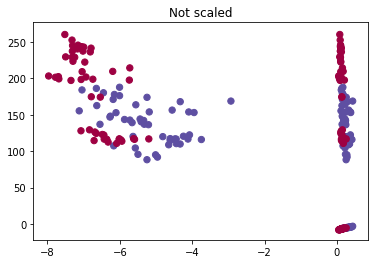

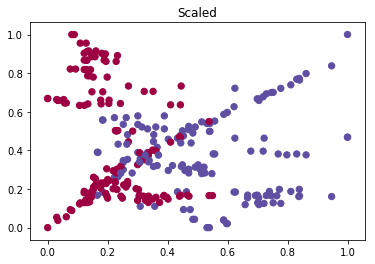

In [8]:
mydata= [22,19,0,1,2]
X_data =  X[:, mydata].astype(np.float64)

plt.scatter(X_data[:,0], X_data[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.scatter(X_data[:,0], X_data[:,2], s=40, c=y, cmap=plt.cm.Spectral)

plt.scatter(X_data[:,1], X_data[:,2], s=40, c=y, cmap=plt.cm.Spectral)
plt.title("Not scaled")
plt.show()


#######################   SCALED    ##########################




X_data_sc =  X_scaled[:, mydata].astype(np.float64)#X[:, [22, 19, 0, 1]] #X[:, [22, 21, 20, 19]]  #X[:, [0,1,2]] 

plt.scatter(X_data_sc[:,0], X_data_sc[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.scatter(X_data_sc[:,0], X_data_sc[:,2], s=40, c=y, cmap=plt.cm.Spectral)

plt.scatter(X_data_sc[:,1], X_data_sc[:,2], s=40, c=y, cmap=plt.cm.Spectral)


plt.title("Scaled")
plt.show()

## Training 

In [338]:
#looking for better parameters
tot = 30
sc = 0.8
j = 0
bestseed = 0
myrange = np.random.randint(0, 10000, (tot))
for i in myrange:
        st = datetime.datetime.now()
        clf = mlp(seed=i, activation="tanh", max_iter=10000, 
                  hidden_layer_size=12, alpha=0.001, momentum=0.9, 
                  tol=1e-3, weight_range=(-1,1), bias=True, classifier=True)

 
        clf.fit(X_data_sc, y)
        predi =  clf.predict(X_data_sc)
        r2 = clf.score(X_data_sc, y) #r2_score(predi, y) 
        delta_t = datetime.datetime.now() - st
        if r2>sc:
            print "-------------------------------"
            #if r2!=1.0:
            print "new best found: ", r2, "seed", i
            print "Estimated remaining time: ", delta_t * (tot - j)
            print "Estimated finishing time: ", datetime.datetime.now() + delta_t * (tot - j)

            sc = r2 
            bestseed = i
            #else:
            # print "Passing overfitting"
        j+=1
        
print "\n\n=======ended======\n\n"
print "Best seed found:", bestseed, "score:", sc
print "Finished at ", datetime.datetime.now()

-------------------------------
new best found:  0.989583333333 seed 9348
Estimated remaining time:  0:00:27.907230
Estimated finishing time:  2018-06-19 15:41:31.161348
-------------------------------
new best found:  1.0 seed 6765
Estimated remaining time:  0:00:10.130340
Estimated finishing time:  2018-06-19 15:41:32.601495


=======ended======


Best seed found: 6765 score: 1.0
Finished at  2018-06-19 15:41:30.789592


CPU times: user 1.16 s, sys: 20.5 ms, total: 1.18 s
Wall time: 1.24 s
Training Error:  0.603549828429
Validation Score:  0.396450171571
Validation R2score:  0.949704180964


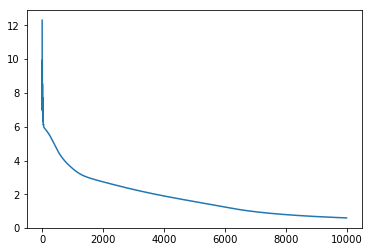

0.809517018247 1.0
0.986254507701 1.0
0.973871054947 1.0
0.988685058197 1.0
0.995792805641 1.0
0.983691166085 1.0
0.543152376618 1.0
0.556937408515 1.0
0.994390361135 1.0
0.999266964867 1.0
0.999933035633 1.0
0.999865367279 1.0
0.917053049333 1.0
0.96887888166 1.0
0.993499948448 1.0
0.984723182955 1.0
0.99399486572 1.0
0.999228298362 1.0
0.995128531159 1.0
0.999970214293 1.0
0.996431637899 1.0
0.994059033685 1.0
0.999239851476 1.0
0.995722058229 1.0
0.996617005191 1.0
0.87817940094 1.0
0.822820903789 1.0
0.988525797059 1.0
0.812021551415 1.0
0.934644103869 1.0
0.998267650589 1.0
0.999300619004 1.0
0.987957876001 1.0
0.958820478481 1.0
0.905183785804 1.0
0.748720717281 1.0
0.974188306444 1.0
0.989424186543 1.0
0.981433466981 1.0
0.947562246655 1.0
0.952898149189 1.0
0.818342706036 1.0
0.989467777214 1.0
0.989775714284 1.0
0.996210937157 1.0
0.997012765496 1.0
0.996904249055 1.0
0.990673555712 1.0
0.151998063491 0.0
-0.0259107741602 0.0
0.180234257069 0.0
-0.0399030966546 0.0
-0.09380843

In [337]:
clf = mlp(seed=4021, activation="tanh", max_iter=10000, 
          hidden_layer_size=12, alpha=0.001, momentum=0.9, 
          tol=1e-3, weight_range=(-1,1), bias=True, classifier=False)

%time clf.fit(X_data_sc, y)
print "Training Error: ", 1 - clf.score(X_data_sc, y)

pred =  clf.predict(X_data_sc)
 
print "Validation Score: ", clf.score(X_data_sc, y) 
print "Validation R2score: ", r2_score(y, pred)

%matplotlib inline
plt.plot(clf.error_list)
#plt.ylim(0, 15)
plt.show()
for i in xrange(pred.shape[0]):
    print pred[i,0], y[i]

### Saving to file

In [262]:
if 0:
    f = open("pd.mlp", "w")
    f.write(pickle.dumps(clf))
    f.close()
    print "Saved"
else:
    print "Not saved"

Not saved


## Genetic Algorithm

In [55]:
class genetic_population_creator():

    def __init__(self, mlp, example_population, population_size=100,
                 class_a_to_b_prop=0.5, crossover_rate=0.5, mutate_rate=0.1, 
                 total_generations=1000, verbose=False, seed=None, error_stop=1e-3, unique=True):
        
        self.mlp = mlp # the instace of the MLP already traine
        self.population = None
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.total_generations = total_generations
        self.verbose = verbose
        self.seed = seed
        self.error_stop = error_stop
        self.unique = unique
        self.errorA = []
        self.errorB = []
        
        #general purpose variables
        self.my_max = np.amax(example_population, axis=0)
        self.my_min = np.amin(example_population, axis=0)         

        self._rank = None
        self.fitnesses = None
        self._fitness_array = None
        self.to_mutate_n = int(population_size * mutate_rate)
        self.to_crossover_n = int(crossover_rate * population_size)
        self.inv_to_crossover_n = int(self.population_size - self.to_crossover_n)
        self.class0_number = int(class_a_to_b_prop * population_size)
        
        
    #creates the population    
    def _create_population(self):
        np.random.seed(self.seed)
        #print my_max, my_min
        pop = [] #CHEAT BELOW
        for mn,mx  in zip(self.my_min, self.my_max):
            if (mn<0) and (mx<0):
                 pop.append(-(np.random.normal(-mx, -mn, (self.population_size))))
            else:
                pop.append(np.random.normal(mn, mx, (self.population_size)))
        
        self.population = np.abs(np.array(pop).T).round(3) #TODO REDO
     
    def _fill_pop(self, sz):
        np.random.seed(self.seed)
        #print my_max, my_min
        pop = [] #CHEAT BELOW
        for mn,mx  in zip(self.my_min, self.my_max):
            if (mn<0) and (mx<0):
                 pop.append(-(np.random.normal(-mx, -mn, (sz))))
            else:
                pop.append(np.random.normal(mn, mx, (sz)))

        return np.abs(np.array(pop).T).round(3) #TODO REDO
    
    #calculates the fitness and ranks the population, the closer to zero, the better
    # returns the rank (numbers from best to worst) and the error list sorted ()
    def _get_fitnesses(self, myclass=0):

        prediction = self.mlp.predict(self.population)[:,0]

        #as we want to set the proportions, there are two fitnesses in one
        # half the pop takes one, the other takes the second
        
        if myclass==0:
            rank_not_sorted = np.abs(prediction) # the closer to 0, the better
        else:
             rank_not_sorted = np.abs(1. - prediction)

        self._rank =  rank_not_sorted.argsort()
        self._fitness_array = np.sort(rank_not_sorted)
    
    #calculates the external final fitness, assumes class a=>0, class b=>1 and resorts the population
    def _final_sorter_grouper(self, class0, class1):  
        pred_class0 = self.mlp.predict(class0)[:,0]
        pred_class1 = self.mlp.predict(class1)[:,0]         
        
        rank_not_sorted_class0 = np.abs(pred_class0)
        rank_not_sorted_class1 = np.abs(1. - pred_class1)
        #print rank_not_sorted_class0.shape, rank_not_sorted_class1.shape
        
        rank_not_sorted = np.hstack((rank_not_sorted_class0[:self.class0_number], 
            rank_not_sorted_class1[self.class0_number:]))
          
        self.population = np.vstack((class0[:self.class0_number, :], class1[self.class0_number:, :]))
        self.population = self.population[rank_not_sorted.argsort()]
        self.fitnesses = np.sort(rank_not_sorted)
        
    # makes the crossover and removes the less fitted (the number of indivuals always stays the same)
    def _crossover(self):
        
        np.random.seed(self.seed)
        
        #print"cross", n_cross, "inv cross" ,inv_n_cross 
        
        # aligning the population to the order of the rank
        self.population = self.population[self._rank]
        #print "\n pop", self.population
        
        #other from all array, to maintain the diversity
        other_elements = np.copy(self._rank)
        np.random.shuffle(other_elements)
        #print "\n shuffle\n", other_elements 
        
        #choosing randomly th point to cross, as it is an odd number
        cross_point = np.random.randint(1, self.population.shape[1])
        #print "\n cross point", cross_point
        
        #crossing the bests with the others and removing excessive data
        rand_pop = self.population[other_elements]
        data = np.hstack((self.population[:, :cross_point], rand_pop[:, cross_point:]))
        #print "\n data\n", data
        
        #adding new individuals to end and removing the worst ones
        #print"cross", n_cross, "inv cross" ,inv_n_cross
        
        #old_pop = self.population[:self.inv_to_crossover_n, :]
        new_pop = data[:self.to_crossover_n, :]
        #print"old", old_pop.shape,"\n new", new_pop.shape 

        #self.population = np.vstack((old_pop, new_pop))
        self.population = np.vstack((self.population, new_pop))
        #print "\n pop\n", self.population
        
    
    # mutates the remaining population
    def _mutate(self):
                
        # no reason to run if not to mutate
        if self.to_mutate_n > 0:
            np.random.seed(self.seed)
            my_array = np.copy(self._rank)
            np.random.shuffle(my_array)
            #indivuals to mutate
            mutated_individuals = my_array[:self.to_mutate_n]
            #mutated cromossomes
            mutated_cromossomes = np.random.randint(0, self.population.shape[1], (self.to_mutate_n))
            #print"\n muatation" 
            #print mutated_individuals, mutated_cromossomes
            
            m_pop = self._fill_pop(self.to_mutate_n)[:, mutated_cromossomes][:, 0]
            #print m_pop
        
            self.population[mutated_individuals, mutated_cromossomes] = m_pop
        
    #trims to the wanted size and removes not unique elements, if wanted
    def _trimmer(self):
        if self.unique:
            pop = self.population[self._rank] #must sort before
            pop_unique = np.unique(pop, axis=0)
            tx = self.population_size - pop_unique.shape[0]  
            if tx > 0:
                pop_fill = self._fill_pop(tx)
                self.population = np.vstack((pop_unique, pop_fill)) # adding new individuals
            else:
                self.population = pop_unique[:self.population_size, :]       
        else:
            pop = self.population[self._rank]
            self.population = pop[:self.population_size, :]
        
        #just executig one time
        self._rank = self._rank[:self.population_size]
        
    #receives noinput and returns the generated population
    def fit(self):
        
        # generating class A
        
        if self.verbose:
            print "Finding class A"
        
        self._create_population()  
        self.errorA = []
        for i in xrange(self.total_generations):
            
            self._get_fitnesses(myclass=0)
            self._crossover()
            self._mutate()
            self._get_fitnesses(myclass=0)
            self._trimmer()
            
            my_tot_error = self._fitness_array.sum()
            self.errorA.append(my_tot_error) 
            if self.verbose:
                print "---> Summed scores: %s"%self._fitness_array.sum()
            if my_tot_error<=self.error_stop:
                print "A stopping by error at %s"%i
                break
        class0 = np.copy(self.population) 


        # generating class B  
        if self.verbose:
            print "Finding class B"
            
        self._create_population()
        self.errorB = []
        for i in xrange(self.total_generations):
            
            self._get_fitnesses(myclass=1)  
            self._crossover()
            self._mutate()
            self._get_fitnesses(myclass=1)
            self._trimmer()
            
            my_tot_error = self._fitness_array.sum()
            self.errorB.append(my_tot_error)
            if self.verbose:
                print "---> Summed scores: %s"%self._fitness_array.sum()
            if my_tot_error<=self.error_stop:
                print "B stopping by error at %s"%i
                break  

        # setting the final rank joining  and the population back together
        self._final_sorter_grouper(class0, self.population)


In [93]:
f = open("pd.mlp", "r")
clf = pickle.loads(f.read())
f.close()
ga = genetic_population_creator(clf, X_data_sc, population_size=10, seed=None,
                     verbose=False, total_generations=200, error_stop=1-10,
                     crossover_rate=0.2, mutate_rate=0.1, class_a_to_b_prop=0.5, unique=True)

In [99]:
%time ga.fit()
print ga.population, ga.population.shape

CPU times: user 194 ms, sys: 5.66 s, total: 5.85 s
Wall time: 5.92 s
[[0.133 0.075 0.498 0.528 0.348]
 [0.1   0.532 0.487 2.039 0.348]
 [0.133 0.075 0.379 0.412 0.562]
 [0.049 0.25  0.872 0.221 0.18 ]
 [0.049 0.25  0.987 0.221 0.304]
 [0.133 0.043 0.685 0.412 1.204]
 [0.133 0.075 0.292 0.481 2.019]
 [0.049 0.25  1.11  0.433 0.304]
 [0.049 0.25  0.987 0.845 0.42 ]
 [0.049 0.25  0.526 0.845 0.18 ]] (10, 5)


In [102]:
print np.version.version, "Unique values"
gxa = np.unique(ga.population, axis=0)
print gxa 
xa = clf.predict(gxa)
print xa[:,0]
print np.where(1, xa>=0.5, 0)[:,0]

1.14.0 Unique values
[[0.049 0.25  0.526 0.845 0.18 ]
 [0.049 0.25  0.872 0.221 0.18 ]
 [0.049 0.25  0.987 0.221 0.304]
 [0.049 0.25  0.987 0.845 0.42 ]
 [0.049 0.25  1.11  0.433 0.304]
 [0.1   0.532 0.487 2.039 0.348]
 [0.133 0.043 0.685 0.412 1.204]
 [0.133 0.075 0.292 0.481 2.019]
 [0.133 0.075 0.379 0.412 0.562]
 [0.133 0.075 0.498 0.528 0.348]]
[-0.15955695  0.09775613  0.09664573 -0.15051031 -0.01414416 -0.73566732
  0.9498037   0.99999999  0.79803742 -0.44627624]
[0 0 0 0 0 0 1 1 1 0]


In [103]:
x = clf.predict(ga.population)
print x[:,0]
print np.where(1, x>=0.5, 0)[:,0]

[-0.44627624 -0.73566732  0.79803742  0.09775613  0.09664573  0.9498037
  0.99999999 -0.01414416 -0.15051031 -0.15955695]
[0 0 1 0 0 1 1 0 0 0]


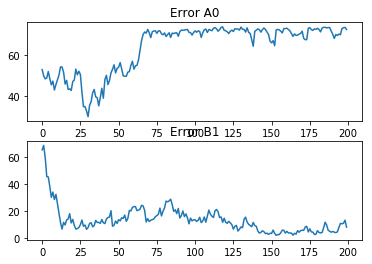

In [92]:
plt.subplot(211)
plt.plot(ga.errorA)
plt.title("Error A0")
plt.subplot(212)
plt.plot(ga.errorB)
plt.title("Error B1")
plt.show()